In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline

color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore') 

from subprocess import check_output
print(check_output(["ls"]).decode("utf8"))

PREDICT_HOUR = 6

1-Data-Exploration-and-Visualization.ipynb
2-Linear-Regression-baseline.ipynb
3-Linear-Regression-lag7-features.ipynb
4-Random-Forest.ipynb
5-Boosted-Decision-tree.ipynb
README.md
input



In [4]:
# Load trip data csv
df_trip = pd.read_csv('input/trip_data.csv',
                      parse_dates=['pickup_datetime', 
                                        'dropoff_datetime'])
print(df_trip.shape)
df_trip.head()
print(df_trip.vendor_id.unique())

(13059961, 14)
['CMT' 'VTS']


In [5]:
# clean data
df_trip_indexed = df_trip.reset_index()

#drop store_and_fwd_flag
df_trip_indexed = df_trip_indexed.drop('store_and_fwd_flag', 1)

# Remove null values
df_trip_indexed = df_trip_indexed.dropna()

# Remove trips with zero passengers
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.passenger_count < 0].index)

# Remove trips with time less than zero
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.trip_time_in_secs < 0].index)

# Remove trips with time greater than 10 hours
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.trip_time_in_secs > 36000].index)


In [6]:
# Generate features based on pickup hour
df_trip_indexed['trip_date'] = df_trip_indexed['pickup_datetime'].dt.date
df_trip_indexed['trip_hour'] = df_trip_indexed['pickup_datetime'].dt.hour
#df = pd.DataFrame(df_trip_indexed.groupby(['pickup_datetime.dt.hour']).count()['index'])
df_trip_indexed.head()


,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_date,trip_hour
0,0,001DFAC01BC0A32F48C3769DD1414778,5A677E8D42137D0006944AF0E4D4488C,CMT,1,2013-01-19 12:37:55,2013-01-19 12:51:26,3,810,3.1,-73.988869,40.736645,-73.957756,40.768227,2013-01-19,12
1,1,001DFAC01BC0A32F48C3769DD1414778,EB99F192B7EA48BE077EE152BB630A4E,CMT,1,2013-01-18 15:16:11,2013-01-18 15:32:51,1,1000,2.6,-73.967781,40.762726,-73.976303,40.788666,2013-01-18,15
2,2,001DFAC01BC0A32F48C3769DD1414778,EB99F192B7EA48BE077EE152BB630A4E,CMT,5,2013-01-18 15:34:56,2013-01-18 16:21:18,1,2782,18.3,-73.974121,40.791367,-74.184647,40.692551,2013-01-18,15
3,3,001DFAC01BC0A32F48C3769DD1414778,AAB8A9FBE9CF2DDCB146CC6EFEDD772F,CMT,5,2013-01-18 23:06:21,2013-01-18 23:26:43,1,1221,5.1,-73.987343,40.738934,-74.035683,40.716774,2013-01-18,23
4,4,001DFAC01BC0A32F48C3769DD1414778,AAB8A9FBE9CF2DDCB146CC6EFEDD772F,CMT,1,2013-01-18 22:18:20,2013-01-18 22:32:08,1,828,3.4,-73.956642,40.771252,-73.955116,40.741486,2013-01-18,22


In [7]:
# Generate trips per hour 
temp = df_trip_indexed.drop(['medallion','hack_license','vendor_id', 'pickup_datetime' ,'rate_code', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=False)
df_trips_ph = pd.DataFrame(temp.groupby(['trip_date', 'trip_hour']).count().reset_index())
df_trips_ph.columns = ['pickup_date', 'pickup_hour', 'trips']
df_trips_ph.head()

,pickup_date,pickup_hour,trips
0,2013-01-01,0,2264
1,2013-01-01,1,2517
2,2013-01-01,2,2276
3,2013-01-01,3,1988
4,2013-01-01,4,1459


In [8]:
#df_trips_ph['p_datetime'] =  df_trips_ph['pickup_date'].astype(str) + ' ' + df_trips_ph['pickup_hour'].astype(str)
#df_trips_ph.head()

df_trips_ph['time'] = df_trips_ph['pickup_hour'].apply(lambda x: "0{0}:00:00".format(x))
df_trips_ph['pickup_dt'] = pd.to_datetime(df_trips_ph['pickup_date'].astype(str) + ' ' + df_trips_ph['time'])
df_trips_ph = df_trips_ph.drop(['time'], axis=1, inplace=False)

df_trips_ph['target_hour'] = (df_trips_ph["pickup_hour"] + PREDICT_HOUR)%24
df_trips_ph.head()


,pickup_date,pickup_hour,trips,pickup_dt,target_hour
0,2013-01-01,0,2264,2013-01-01 00:00:00,6
1,2013-01-01,1,2517,2013-01-01 01:00:00,7
2,2013-01-01,2,2276,2013-01-01 02:00:00,8
3,2013-01-01,3,1988,2013-01-01 03:00:00,9
4,2013-01-01,4,1459,2013-01-01 04:00:00,10


In [9]:
df_trips_ph['target_dt'] = df_trips_ph.pickup_dt + pd.to_timedelta(PREDICT_HOUR, unit='h')
df_trips_ph.head()

,pickup_date,pickup_hour,trips,pickup_dt,target_hour,target_dt
0,2013-01-01,0,2264,2013-01-01 00:00:00,6,2013-01-01 06:00:00
1,2013-01-01,1,2517,2013-01-01 01:00:00,7,2013-01-01 07:00:00
2,2013-01-01,2,2276,2013-01-01 02:00:00,8,2013-01-01 08:00:00
3,2013-01-01,3,1988,2013-01-01 03:00:00,9,2013-01-01 09:00:00
4,2013-01-01,4,1459,2013-01-01 04:00:00,10,2013-01-01 10:00:00


In [10]:
# Gerenate target trips to be predicted
temp = df_trips_ph
df_join = pd.merge(temp, df_trips_ph, left_on='target_dt', right_on='pickup_dt', how='inner')

#df_join.head(20)
result = df_join.drop([ 'pickup_date_y', 'pickup_hour_y','target_hour_y' , 'target_dt_y', 'pickup_dt_y'], axis=1, inplace=False)
result.columns = ['pickup_date', 'pickup_hour', 'pickup_trips','pickup_dt', 'target_hour', 'target_dt', 'target_trips']
result['target_day'] = result['target_dt'].dt.day
result = result.drop([ 'pickup_date', 'pickup_hour','target_dt'], axis=1, inplace=False)
result = result.reset_index()
result.head(10)


,index,pickup_trips,pickup_dt,target_hour,target_trips,target_day
0,0,2264,2013-01-01 00:00:00,6,682,1
1,1,2517,2013-01-01 01:00:00,7,523,1
2,2,2276,2013-01-01 02:00:00,8,414,1
3,3,1988,2013-01-01 03:00:00,9,540,1
4,4,1459,2013-01-01 04:00:00,10,801,1
5,5,866,2013-01-01 05:00:00,11,1149,1
6,6,682,2013-01-01 06:00:00,12,1435,1
7,7,523,2013-01-01 07:00:00,13,1507,1
8,8,414,2013-01-01 08:00:00,14,1551,1
9,9,540,2013-01-01 09:00:00,15,1549,1


In [11]:
# Add lag features to capture sesonality in data
result['day_lag_0'] = result.groupby(['target_day'])['pickup_trips'].shift(0)
result['day_lag_1'] = result.groupby(['target_day'])['pickup_trips'].shift(1)
result['day_lag_2'] = result.groupby(['target_day'])['pickup_trips'].shift(2)
result['day_lag_3'] = result.groupby(['target_day'])['pickup_trips'].shift(3)
result['day_lag_4'] = result.groupby(['target_day'])['pickup_trips'].shift(4)
result['day_lag_5'] = result.groupby(['target_day'])['pickup_trips'].shift(5)
result['day_lag_6'] = result.groupby(['target_day'])['pickup_trips'].shift(6)

result['hour_lag_0'] = result.groupby(['target_hour'])['pickup_trips'].shift(0)
result['hour_lag_1'] = result.groupby(['target_hour'])['pickup_trips'].shift(1)
result['hour_lag_2'] = result.groupby(['target_hour'])['pickup_trips'].shift(2)
result['hour_lag_3'] = result.groupby(['target_hour'])['pickup_trips'].shift(3)
result['hour_lag_4'] = result.groupby(['target_hour'])['pickup_trips'].shift(4)
result['hour_lag_5'] = result.groupby(['target_hour'])['pickup_trips'].shift(5)
result['hour_lag_6'] = result.groupby(['target_hour'])['pickup_trips'].shift(6)
result.head()

,index,pickup_trips,pickup_dt,target_hour,target_trips,target_day,day_lag_0,day_lag_1,day_lag_2,day_lag_3,day_lag_4,day_lag_5,day_lag_6,hour_lag_0,hour_lag_1,hour_lag_2,hour_lag_3,hour_lag_4,hour_lag_5,hour_lag_6
0,0,2264,2013-01-01 00:00:00,6,682,1,2264,NaN,NaN,NaN,NaN,NaN,NaN,2264,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2517,2013-01-01 01:00:00,7,523,1,2517,2264.0,NaN,NaN,NaN,NaN,NaN,2517,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2276,2013-01-01 02:00:00,8,414,1,2276,2517.0,2264.0,NaN,NaN,NaN,NaN,2276,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1988,2013-01-01 03:00:00,9,540,1,1988,2276.0,2517.0,2264.0,NaN,NaN,NaN,1988,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1459,2013-01-01 04:00:00,10,801,1,1459,1988.0,2276.0,2517.0,2264.0,NaN,NaN,1459,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train = result.drop(['pickup_dt'], axis=1, inplace=False)
train.columns

Index(['index', 'pickup_trips', 'target_hour', 'target_trips', 'target_day',
       'day_lag_0', 'day_lag_1', 'day_lag_2', 'day_lag_3', 'day_lag_4',
       'day_lag_5', 'day_lag_6', 'hour_lag_0', 'hour_lag_1', 'hour_lag_2',
       'hour_lag_3', 'hour_lag_4', 'hour_lag_5', 'hour_lag_6'],
      dtype='object')

In [13]:
import statsmodels.formula.api as sm
train.head()
res = sm.ols(formula="target_trips ~ target_hour + target_day + pickup_trips + day_lag_0 + day_lag_1 + day_lag_2 + day_lag_3 + day_lag_4 + day_lag_5 + day_lag_6 + hour_lag_0 + hour_lag_1 + hour_lag_2 + hour_lag_3 + hour_lag_4 + hour_lag_5 + hour_lag_6", data=train).fit()

In [14]:
print(res.params)

Intercept       739.949231
target_hour      66.905595
target_day       -0.244178
pickup_trips      0.068758
day_lag_0         0.068758
day_lag_1         0.206362
day_lag_2        -0.676689
day_lag_3         0.001745
day_lag_4         0.201747
day_lag_5         0.032522
day_lag_6         0.115667
hour_lag_0        0.068758
hour_lag_1       -0.059753
hour_lag_2        0.035135
hour_lag_3        0.026249
hour_lag_4       -0.018176
hour_lag_5        0.072266
hour_lag_6       -0.149338
dtype: float64


In [15]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           target_trips   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     647.7
Date:                Thu, 27 Jul 2017   Prob (F-statistic):               0.00
Time:                        03:15:12   Log-Likelihood:                -63690.
No. Observations:                8464   AIC:                         1.274e+05
Df Residuals:                    8448   BIC:                         1.275e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      739.9492     27.895     26.526   

In [16]:
train['predicted_trips'] = res.fittedvalues
train.tail(10)

,index,pickup_trips,target_hour,target_trips,target_day,day_lag_0,day_lag_1,day_lag_2,day_lag_3,day_lag_4,day_lag_5,day_lag_6,hour_lag_0,hour_lag_1,hour_lag_2,hour_lag_3,hour_lag_4,hour_lag_5,hour_lag_6,predicted_trips
8742,8742,1031,14,1922,31,1031,763.0,429.0,259.0,288.0,445.0,669.0,1031,1102.0,542.0,525.0,1005.0,816.0,355.0,1853.952799
8743,8743,1248,15,1795,31,1248,1031.0,763.0,429.0,259.0,288.0,445.0,1248,1329.0,839.0,882.0,1171.0,987.0,444.0,1760.632531
8744,8744,1313,16,1547,31,1313,1248.0,1031.0,763.0,429.0,259.0,288.0,1313,1315.0,1240.0,1131.0,1261.0,1106.0,694.0,1711.241961
8745,8745,1506,17,1972,31,1506,1313.0,1248.0,1031.0,763.0,429.0,259.0,1506,1452.0,1601.0,1355.0,1365.0,1200.0,889.0,1740.715216
8746,8746,1719,18,2100,31,1719,1506.0,1313.0,1248.0,1031.0,763.0,429.0,1719,1615.0,1926.0,1426.0,1518.0,1392.0,988.0,1932.225316
8747,8747,1825,19,2460,31,1825,1719.0,1506.0,1313.0,1248.0,1031.0,763.0,1825,1695.0,2036.0,1612.0,1527.0,1410.0,1075.0,2017.703045
8748,8748,1922,20,2629,31,1922,1825.0,1719.0,1506.0,1313.0,1248.0,1031.0,1922,1719.0,1947.0,1517.0,1614.0,1323.0,1120.0,2012.219726
8749,8749,1795,21,2639,31,1795,1922.0,1825.0,1719.0,1506.0,1313.0,1248.0,1795,1731.0,1917.0,1586.0,1641.0,1443.0,1093.0,2079.992831
8750,8750,1547,22,2409,31,1547,1795.0,1922.0,1825.0,1719.0,1506.0,1313.0,1547,1530.0,1627.0,1311.0,1312.0,1379.0,1044.0,2064.123215
8751,8751,1972,23,1763,31,1972,1547.0,1795.0,1922.0,1825.0,1719.0,1506.0,1972,1716.0,1566.0,1525.0,1664.0,1607.0,1101.0,2298.188564


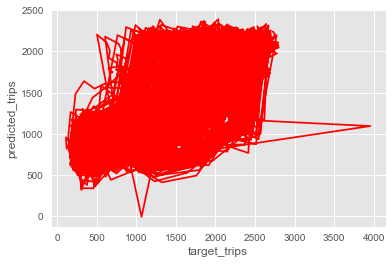

In [17]:
x = train['target_trips']
y = train['predicted_trips']
plt.plot(x, y, 'r-')
plt.xlabel('target_trips')
plt.ylabel('predicted_trips')
plt.show()

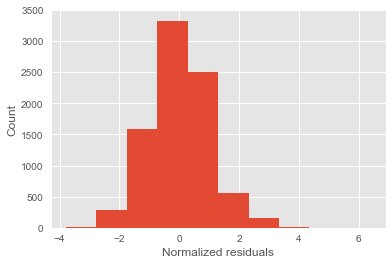

In [18]:
#fitted = res.fit()
plt.hist(res.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')